### PFA skin type and condition model partie 1 

In [1]:
import os
import torch
import numpy as np
import torch.nn as nn
import seaborn as sns
import torch.optim as optim
from torchinfo import summary
import matplotlib.pyplot as plt
from collections import defaultdict
from torchvision.transforms import RandAugment
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.metrics import classification_report, confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print(f"GPU name: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'No GPU'}")

PyTorch version: 2.5.1+cu121
CUDA available: True
CUDA version: 12.1
GPU name: NVIDIA GeForce RTX 4060 Laptop GPU


### check if the dataset is imbalaced or not

In [3]:
data_transforms = {
    'train': transforms.Compose([
        RandAugment(),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),  
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.RandomErasing(p=0.5, scale=(0.02, 0.2)),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

def load_ds(name):
    return(os.path.join("C:/Users/salma/OneDrive/Documents/pfa/dataset",name).replace('\\','/') )
    
skin_type=load_ds('Skin-Types')  
skin_cond=load_ds('face_condition_split')



Class distribution for train set:
Class: dry, Samples: 652, Percentage: 23.66%
Class: normal, Samples: 1104, Percentage: 40.06%
Class: oily, Samples: 1000, Percentage: 36.28%
Imbalance ratio (max/min): 1.69
This set appears balanced (ratio <= 2).


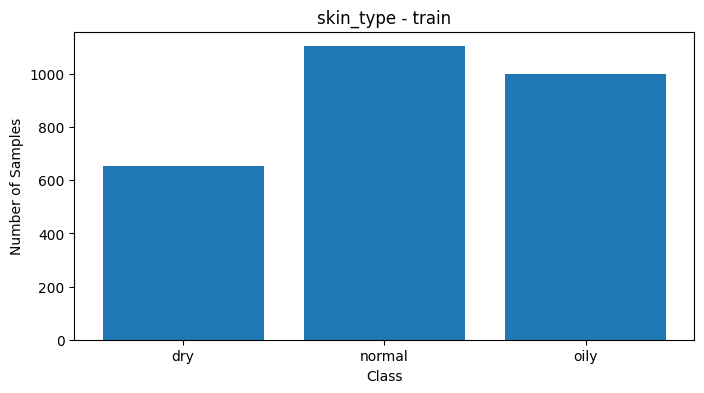


Class distribution for val set:
Class: dry, Samples: 71, Percentage: 27.10%
Class: normal, Samples: 111, Percentage: 42.37%
Class: oily, Samples: 80, Percentage: 30.53%
Imbalance ratio (max/min): 1.56
This set appears balanced (ratio <= 2).


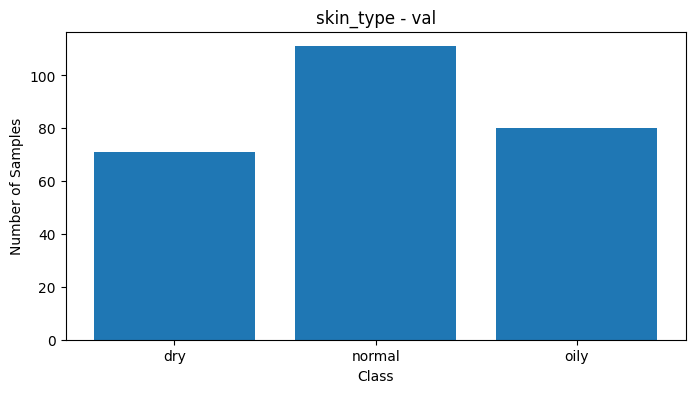


Class distribution for test set:
Class: dry, Samples: 35, Percentage: 26.12%
Class: normal, Samples: 59, Percentage: 44.03%
Class: oily, Samples: 40, Percentage: 29.85%
Imbalance ratio (max/min): 1.69
This set appears balanced (ratio <= 2).


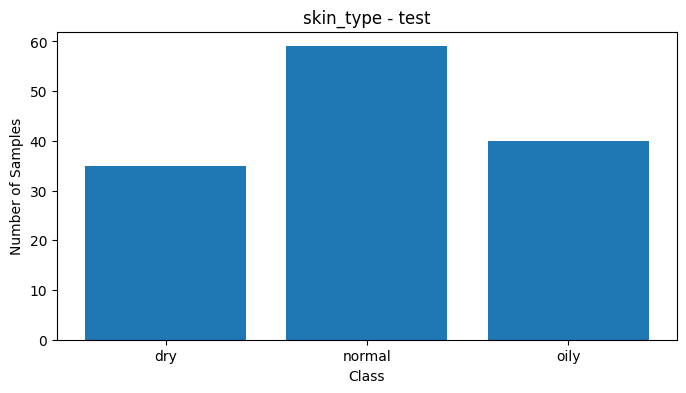


Class distribution for train set:
Class: Acne, Samples: 319, Percentage: 16.67%
Class: Carcinoma, Samples: 319, Percentage: 16.67%
Class: Eczema, Samples: 319, Percentage: 16.67%
Class: Keratosis, Samples: 319, Percentage: 16.67%
Class: Milia, Samples: 319, Percentage: 16.67%
Class: Rosacea, Samples: 319, Percentage: 16.67%
Imbalance ratio (max/min): 1.00
This set appears balanced (ratio <= 2).


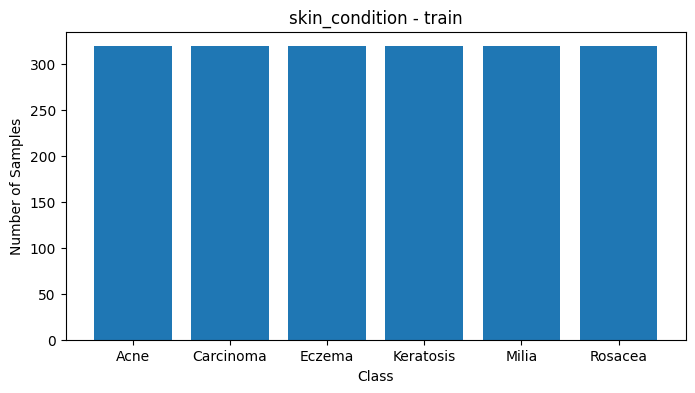


Class distribution for val set:
Class: Acne, Samples: 66, Percentage: 16.67%
Class: Carcinoma, Samples: 66, Percentage: 16.67%
Class: Eczema, Samples: 66, Percentage: 16.67%
Class: Keratosis, Samples: 66, Percentage: 16.67%
Class: Milia, Samples: 66, Percentage: 16.67%
Class: Rosacea, Samples: 66, Percentage: 16.67%
Imbalance ratio (max/min): 1.00
This set appears balanced (ratio <= 2).


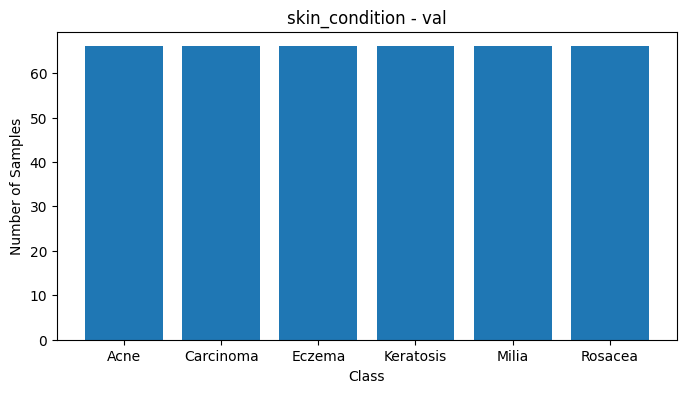


Class distribution for test set:
Class: Acne, Samples: 71, Percentage: 16.67%
Class: Carcinoma, Samples: 71, Percentage: 16.67%
Class: Eczema, Samples: 71, Percentage: 16.67%
Class: Keratosis, Samples: 71, Percentage: 16.67%
Class: Milia, Samples: 71, Percentage: 16.67%
Class: Rosacea, Samples: 71, Percentage: 16.67%
Imbalance ratio (max/min): 1.00
This set appears balanced (ratio <= 2).


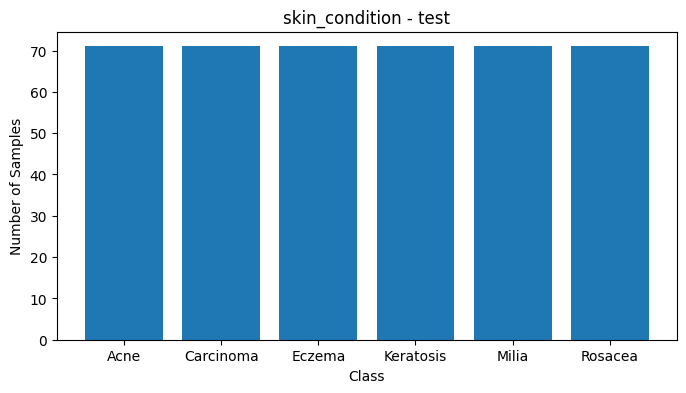

In [4]:
splits = ['train', 'val', 'test']
def count_samples_per_class(data_dir, split):
    class_counts = defaultdict(int)
    split_dir = os.path.join(data_dir, split) 
    for class_name in os.listdir(split_dir):
        class_path = os.path.join(split_dir, class_name)
        if os.path.isdir(class_path):
            num_samples = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f) )])
            class_counts[class_name] = num_samples
    
    return class_counts

def check_each_ds (data_dir,nameds):
    for split in splits:
        print(f"\nClass distribution for {split} set:")
        class_counts = count_samples_per_class(data_dir, split) 
        total_samples = sum(class_counts.values())
        for class_name, count in class_counts.items():
            percentage = (count / total_samples) * 100 if total_samples > 0 else 0
            print(f"Class: {class_name}, Samples: {count}, Percentage: {percentage:.2f}%")
        if class_counts:
            max_count = max(class_counts.values())
            min_count = min(class_counts.values())
            imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')
            print(f"Imbalance ratio (max/min): {imbalance_ratio:.2f}")
            if imbalance_ratio > 2:
                print("Warning: This set is imbalanced (ratio > 2).")
            else:
                print("This set appears balanced (ratio <= 2).")
        plt.figure(figsize=(8, 4))
        plt.bar(class_counts.keys(), class_counts.values())
        plt.title(f"{nameds} - {split}")
        plt.xlabel("Class")
        plt.ylabel("Number of Samples")
        plt.show()

check_each_ds(skin_type,'skin_type')
check_each_ds(skin_cond,'skin_condition')

### Building the model

In [5]:
def prepare_model(data_dir):
    image_datasets = {
        x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
        for x in splits
    }
    
    class_counts_dict = count_samples_per_class(data_dir, 'train')
    class_names = image_datasets['train'].classes
    print(f"Class names: {class_names}")
    print(f"Class counts: {class_counts_dict}")
    class_counts = [class_counts_dict[cls] for cls in class_names]
    if not class_counts or min(class_counts) == 0:
        raise ValueError("No samples found for one or more classes in the training set.")
        
    total = sum(class_counts)
    class_weights = [(total/count) ** 0.5 for count in class_counts]
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
    print(f"Class weights: {class_weights.tolist()}")

    train_targets = [sample[1] for sample in image_datasets['train'].samples]
    sample_weights = [class_weights[target].item() for target in train_targets]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

    dataloaders = {
        'train': DataLoader(image_datasets['train'], batch_size=32, sampler=sampler, num_workers=8),
        'val': DataLoader(image_datasets['val'], batch_size=32, shuffle=False, num_workers=8),
        'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=False, num_workers=8)
    }
    dataset_sizes = {x: len(image_datasets[x]) for x in splits}
    num_classes = len(class_names)

    model = models.efficientnet_b0(weights=None)
    for param in model.parameters():
        param.requires_grad = True
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Sequential(
        nn.Dropout(0.7),  
        nn.Linear(num_ftrs, num_classes)
    )
    model = model.to(device)

    print("\nModel Summary:")
    summary(model, input_size=(16, 3, 224, 224), device=str(device))

    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=0.00005, weight_decay=1e-4)
    return model, criterion, optimizer, dataloaders, dataset_sizes



### Training the model

In [6]:
def train_model(model, criterion, optimizer, dataloaders, dataset_sizes, num_epochs=30, patience=15):
    scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1, end_factor=1.0, total_iters=5)
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_wts = model.state_dict()
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            if phase == 'train':
                train_losses.append(epoch_loss)
            else:
                val_losses.append(epoch_loss)
                if epoch_loss < best_val_loss:
                    best_val_loss = epoch_loss
                    best_model_wts = model.state_dict()
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
                scheduler.step(epoch_loss)
                if epochs_no_improve >= patience:
                    print(f'Early stopping at epoch {epoch+1}')
                    model.load_state_dict(best_model_wts)
                    
                    plt.figure(figsize=(20, 15))
                    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
                    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
                    plt.xlabel('Epoch')
                    plt.ylabel('Loss')
                    plt.title('Training and Validation Loss Curves')
                    plt.legend()
                    plt.grid(True)
                    plt.show()
                    return model
                    
    model.load_state_dict(best_model_wts)

    plt.figure(figsize=(20, 15))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return model

### Evaluation

In [7]:
def evaluate_model(model, dataloaders, dataset_sizes, phase='test'):
    model.eval()
    all_preds = []
    all_labels = []
    class_names = dataloaders[phase].dataset.classes

    with torch.no_grad():
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f'{phase} Accuracy: {accuracy:.4f}')

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    print("\nConfusion Matrix:")
    print(cm)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {phase}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


Class names: ['dry', 'normal', 'oily']
Class counts: defaultdict(<class 'int'>, {'dry': 652, 'normal': 1104, 'oily': 1000})
Class weights: [2.0559654235839844, 1.579992651939392, 1.6601204872131348]

Model Summary:
Epoch 1/30
----------
train Loss: 1.1466 Acc: 0.3451
val Loss: 1.0968 Acc: 0.3053
Epoch 2/30
----------


C:\Users\salma\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


train Loss: 1.1295 Acc: 0.3454
val Loss: 1.1083 Acc: 0.2977
Epoch 3/30
----------
train Loss: 1.1297 Acc: 0.3556
val Loss: 1.1044 Acc: 0.2901
Epoch 4/30
----------
train Loss: 1.1399 Acc: 0.3407
val Loss: 1.1041 Acc: 0.3130
Epoch 5/30
----------
train Loss: 1.1384 Acc: 0.3447
val Loss: 1.1057 Acc: 0.2863
Epoch 6/30
----------
train Loss: 1.1334 Acc: 0.3454
val Loss: 1.1005 Acc: 0.3015
Epoch 7/30
----------
train Loss: 1.1293 Acc: 0.3313
val Loss: 1.1068 Acc: 0.3244
Epoch 8/30
----------
train Loss: 1.1322 Acc: 0.3313
val Loss: 1.1046 Acc: 0.3053
Epoch 9/30
----------
train Loss: 1.1360 Acc: 0.3215
val Loss: 1.1029 Acc: 0.3053
Epoch 10/30
----------
train Loss: 1.1422 Acc: 0.3135
val Loss: 1.0979 Acc: 0.3130
Epoch 11/30
----------
train Loss: 1.1395 Acc: 0.3411
val Loss: 1.1029 Acc: 0.3206
Epoch 12/30
----------
train Loss: 1.1320 Acc: 0.3403
val Loss: 1.0963 Acc: 0.3359
Epoch 13/30
----------
train Loss: 1.1302 Acc: 0.3324
val Loss: 1.0971 Acc: 0.3321
Epoch 14/30
----------
train Loss:

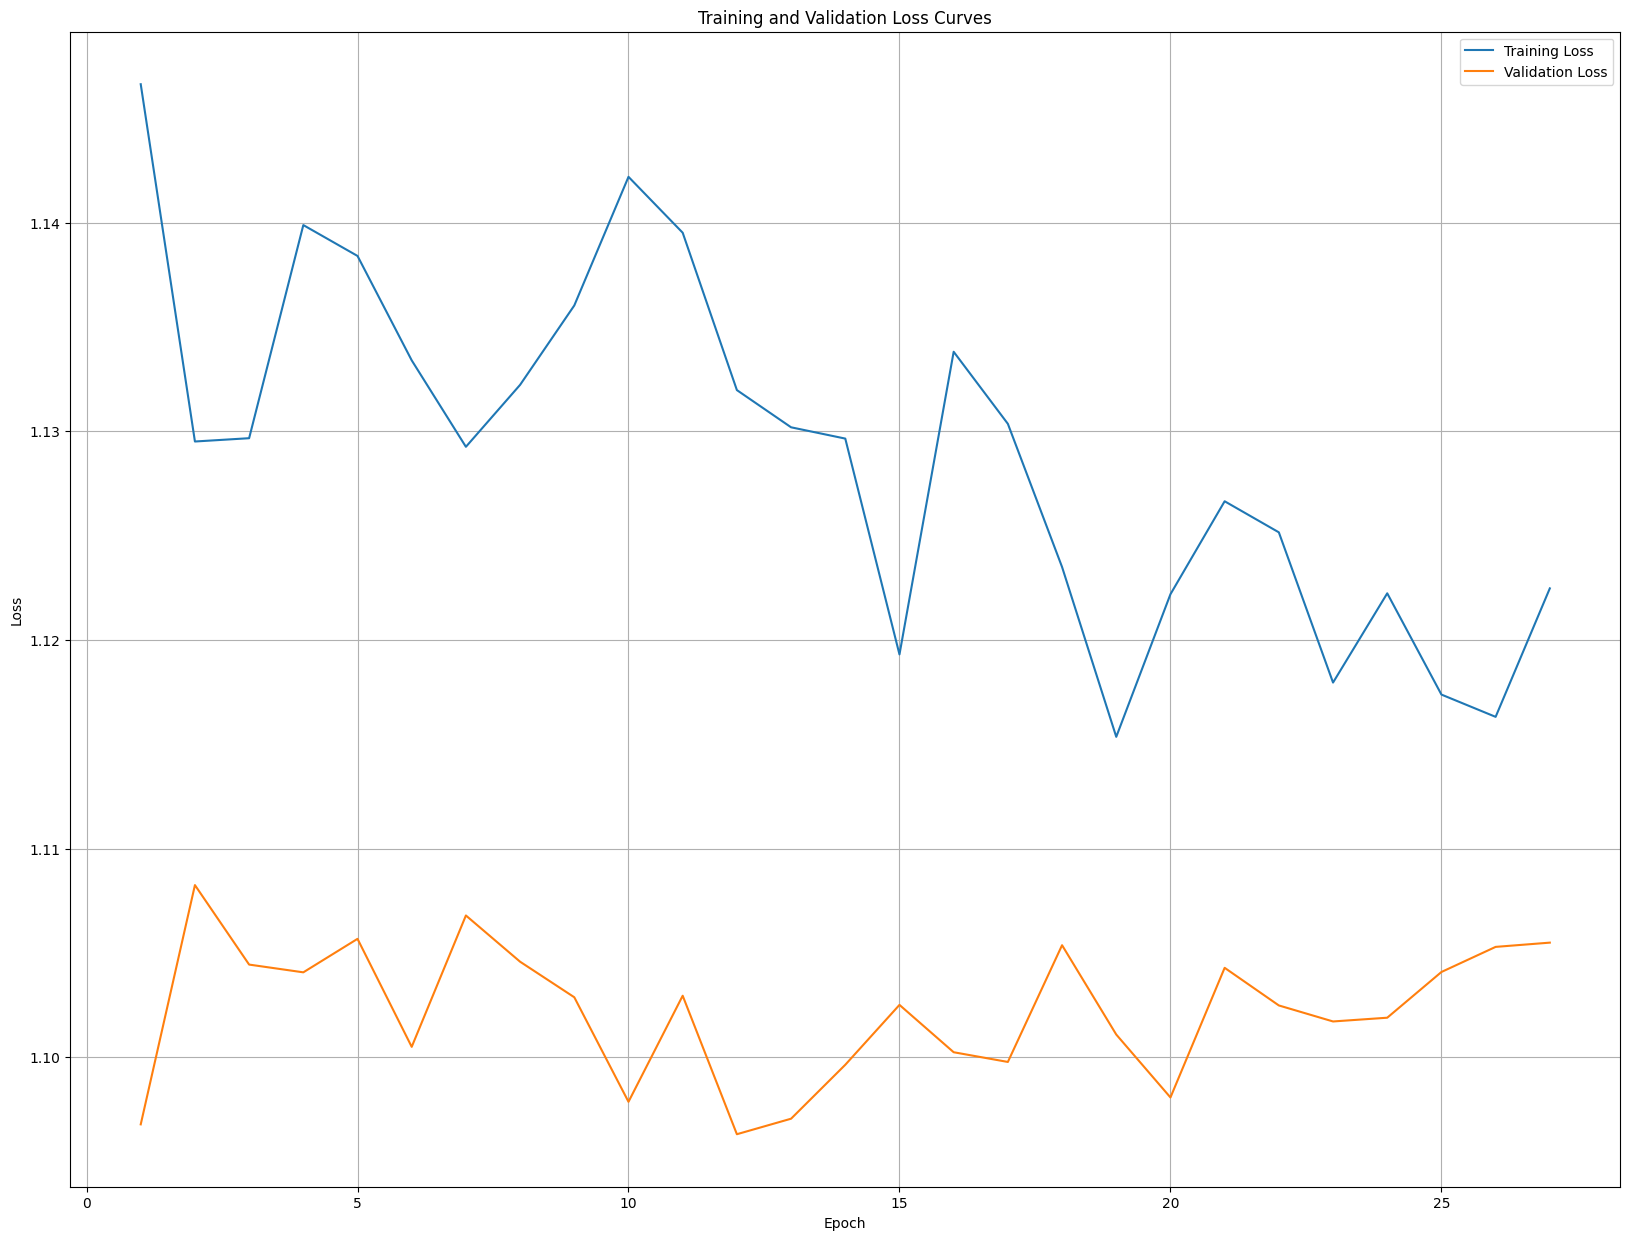

In [8]:
modeltype, criteriontype, optimizertype, dataloaderstype, dataset_sizestype= prepare_model(skin_type)
modeltype=train_model(modeltype, criteriontype, optimizertype, dataloaderstype, dataset_sizestype)

test Accuracy: 0.2761

Classification Report:
              precision    recall  f1-score   support

         dry       0.25      0.69      0.36        35
      normal       0.40      0.03      0.06        59
        oily       0.34      0.28      0.31        40

    accuracy                           0.28       134
   macro avg       0.33      0.33      0.24       134
weighted avg       0.34      0.28      0.21       134


Confusion Matrix:
[[24  3  8]
 [44  2 13]
 [29  0 11]]


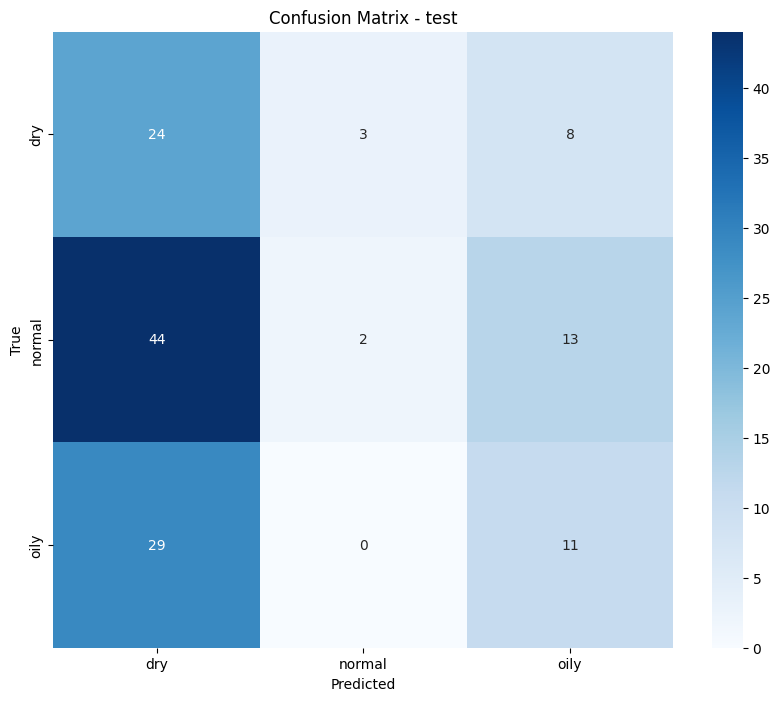

In [9]:
evaluate_model(modeltype, dataloaderstype, dataset_sizestype, phase='test')

Class names: ['Acne', 'Carcinoma', 'Eczema', 'Keratosis', 'Milia', 'Rosacea']
Class counts: defaultdict(<class 'int'>, {'Acne': 319, 'Carcinoma': 319, 'Eczema': 319, 'Keratosis': 319, 'Milia': 319, 'Rosacea': 319})
Class weights: [2.4494898319244385, 2.4494898319244385, 2.4494898319244385, 2.4494898319244385, 2.4494898319244385, 2.4494898319244385]

Model Summary:
Epoch 1/20
----------
train Loss: 1.8530 Acc: 0.1698
val Loss: 1.7928 Acc: 0.1667
Epoch 2/20
----------


C:\Users\salma\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


train Loss: 1.8646 Acc: 0.1578
val Loss: 1.7923 Acc: 0.1591
Epoch 3/20
----------
train Loss: 1.8556 Acc: 0.1672
val Loss: 1.7926 Acc: 0.1717
Epoch 4/20
----------
train Loss: 1.8436 Acc: 0.1698
val Loss: 1.7920 Acc: 0.1692
Epoch 5/20
----------
train Loss: 1.8336 Acc: 0.2011
val Loss: 1.7928 Acc: 0.1742
Epoch 6/20
----------
train Loss: 1.8376 Acc: 0.1928
val Loss: 1.7929 Acc: 0.1566
Epoch 7/20
----------
train Loss: 1.8326 Acc: 0.1782
val Loss: 1.7919 Acc: 0.1616
Epoch 8/20
----------
train Loss: 1.8329 Acc: 0.1803
val Loss: 1.7906 Acc: 0.1818
Epoch 9/20
----------
train Loss: 1.8405 Acc: 0.1818
val Loss: 1.7864 Acc: 0.1919
Epoch 10/20
----------
train Loss: 1.8383 Acc: 0.1897
val Loss: 1.7837 Acc: 0.1793
Epoch 11/20
----------
train Loss: 1.8252 Acc: 0.1949
val Loss: 1.7767 Acc: 0.1970
Epoch 12/20
----------
train Loss: 1.8276 Acc: 0.1808
val Loss: 1.7795 Acc: 0.1995
Epoch 13/20
----------
train Loss: 1.8066 Acc: 0.2085
val Loss: 1.7771 Acc: 0.1843
Epoch 14/20
----------
train Loss:

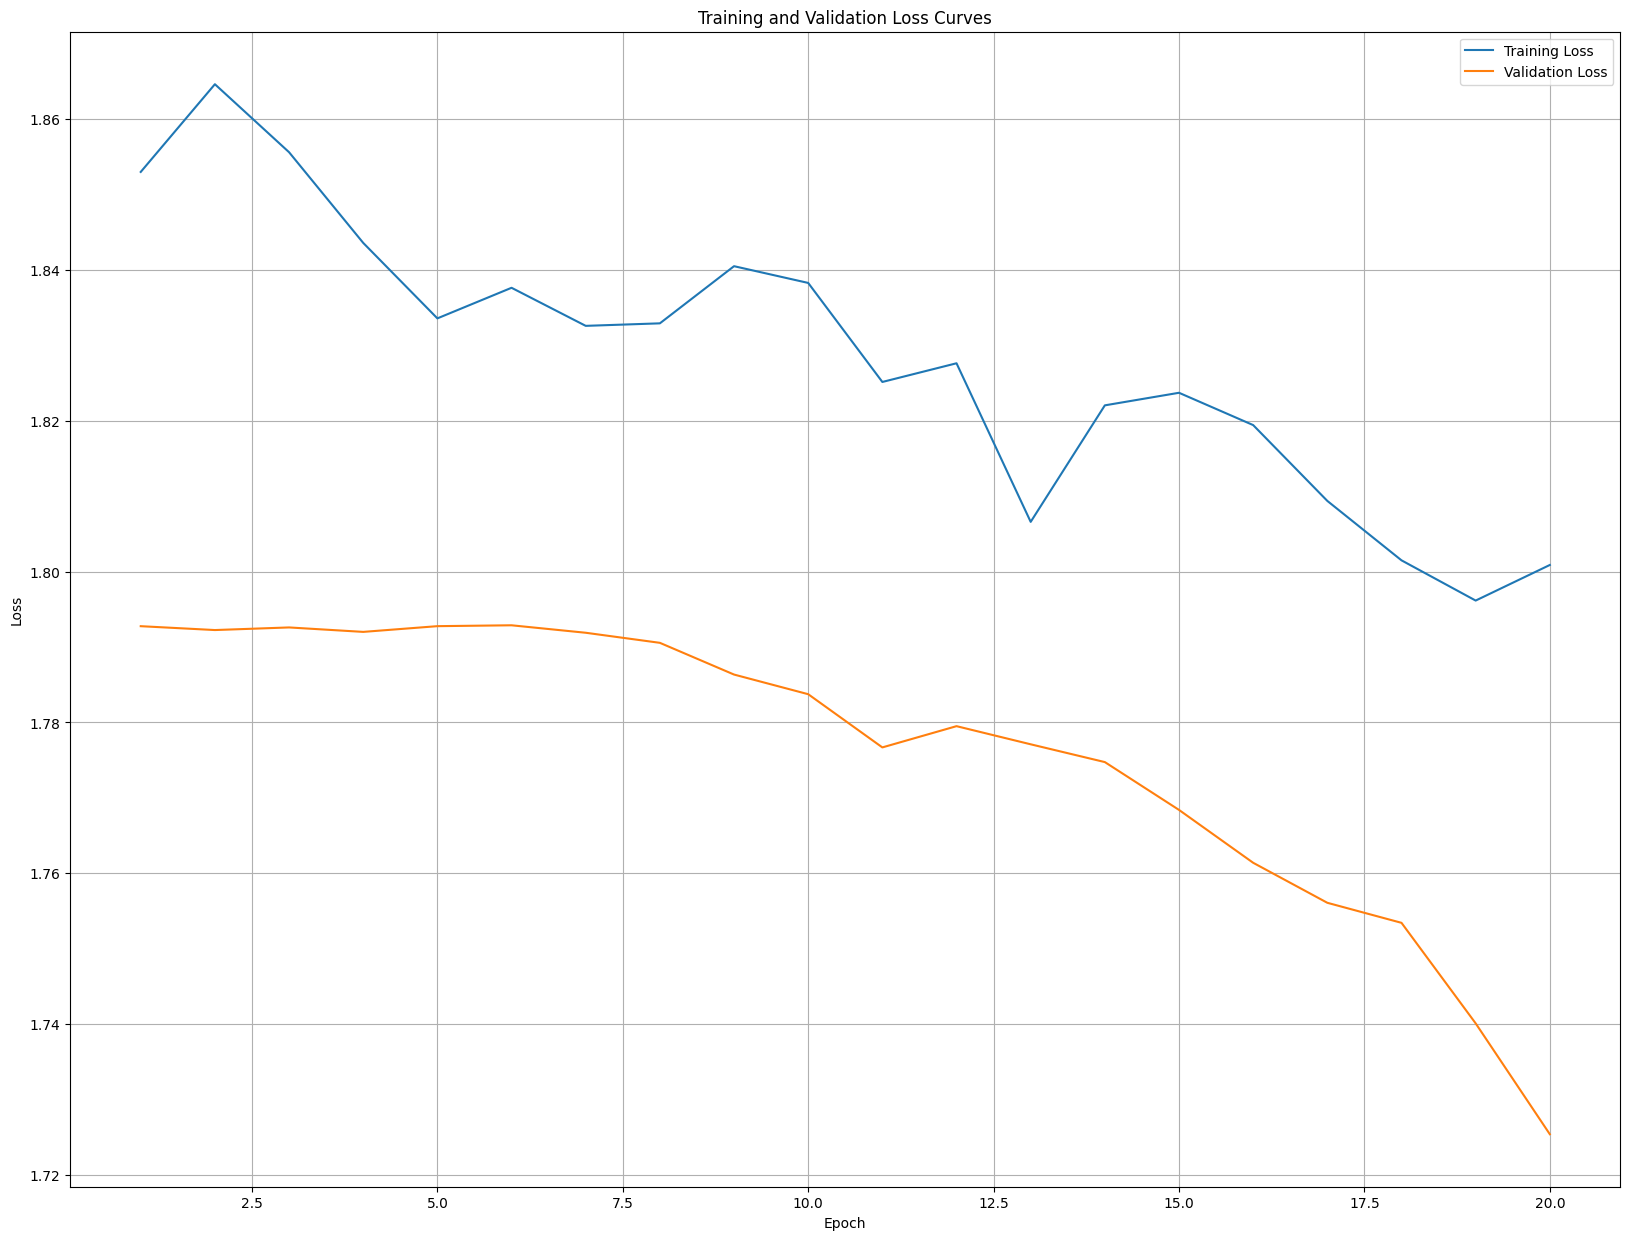

In [10]:
modelcond, criterioncond, optimizercond, dataloaderscond, dataset_sizescond= prepare_model(skin_cond)
modelcond=train_model(modelcond, criterioncond, optimizercond, dataloaderscond, dataset_sizescond, num_epochs=20)

test Accuracy: 0.2817

Classification Report:
              precision    recall  f1-score   support

        Acne       0.21      0.55      0.30        71
   Carcinoma       0.00      0.00      0.00        71
      Eczema       0.27      0.35      0.31        71
   Keratosis       0.40      0.42      0.41        71
       Milia       0.29      0.11      0.16        71
     Rosacea       0.43      0.25      0.32        71

    accuracy                           0.28       426
   macro avg       0.27      0.28      0.25       426
weighted avg       0.27      0.28      0.25       426


Confusion Matrix:
[[39  0 21  6  2  3]
 [32  0 22  6  6  5]
 [30  0 25 11  3  2]
 [23  0  3 30  6  9]
 [31  0 16 11  8  5]
 [35  0  4 11  3 18]]


C:\Users\salma\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\salma\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\salma\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

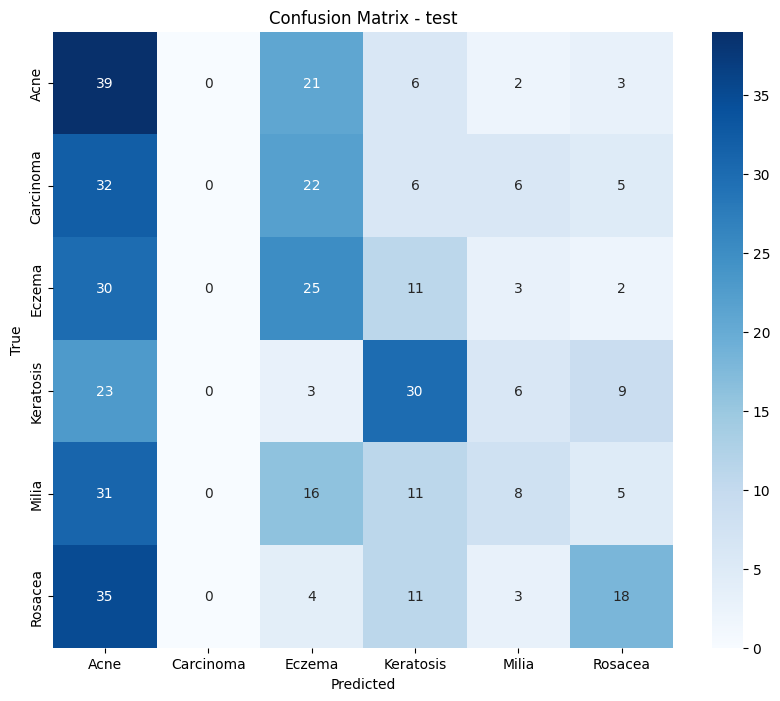

In [11]:
evaluate_model(modelcond, dataloaderscond, dataset_sizescond, phase='test')